# Part 1: Analyze the network

Present an analysis/description of the network of bands/artists using tools from Lecture 5. Imagine that you have been tasked with presenting the important facts about the network to an audience who knows about network science, but doesn't know about this particular network.
- It's OK to also use basic concepts like degree distributions (even though they're from week 4) in your analysis. That way you can make the analysis a standalone, coherent thing.
- I would like you to include concepts like centrality and assortativity in your analysis.
- Use a network backbone in your analysis.
- In addition to standard distribution plots (e.g. degree distributions, etc), your analysis should also include at least one network visualization (but it doesn't have to display the entire network, you can also visualize a network backbone).
- Note: As I write above, an important part of the exercise consists is selecting the right elements of the lecture to create a meaningful analysis. So don't solve this part by going exhaustive and just calculating everything you can think of in one massive analysis. Try to focus on using what you've learned to characterize the network.

## Analysis
In our analysis of the network of rock artists, we found that the network is directed and heterogeneous. Nodes represent artists, and edges represent links between them. Some artists are much more connected than others, which reflects differences in popularity and activity.

#### Degree distributions:

The in-degree distribution follows a power law with exponent α = 2.56, which means that a few artists get a lot of incoming links (are “famous”), while most have very few. This shows a rich-get-richer effect.

The out-degree distribution has a very steep exponent α = 6.47, meaning most artists link to only a few others. The network looks more random on the out-degree side.

The total degree has an exponent α = 3.65, which indicates a moderately connected network with some small-world characteristics.

#### Content length and connectivity:

Longer articles tend to include more outgoing links and also receive more incoming links.

The correlations support this:

Out-degree vs length: Spearman 0.73, Pearson 0.69

In-degree vs length: Spearman 0.68, Pearson 0.68

This shows that more detailed pages are both more active (link to more artists) and more popular (linked by more artists). The effect is slightly stronger for out-degree, meaning longer articles link to more artists slightly more than they attract links.

#### Centrality:

The node with the highest degree centrality has a value of 0.33, meaning it links to about a third of all nodes.

The node with the highest betweenness centrality has a value of 0.03, indicating that no single artist acts as a major bridge for the network. Information can flow through multiple paths.

#### Connectivity patterns:

Less famous artists (low in-degree) tend to include proportionally more outgoing links in their pages, while highly famous artists (high in-degree) include fewer. This shows an asymmetry between activity and popularity.

#### Conclusion:
Overall, the network is partially scale-free in terms of in-degree, asymmetric, and moderately connected. Longer articles seem to help both activity and fame. The network’s hubs are important but not critical for connecting the entire network, and most artists link only to a few others.

Lasly, we provide a plot of our network backbone. We added the normalized edge betweeness centrality as edge weights and followed the implementation of disparity filter from https://www.michelecoscia.com/?page_id=287. Finally, we plot it using AtlasForce2

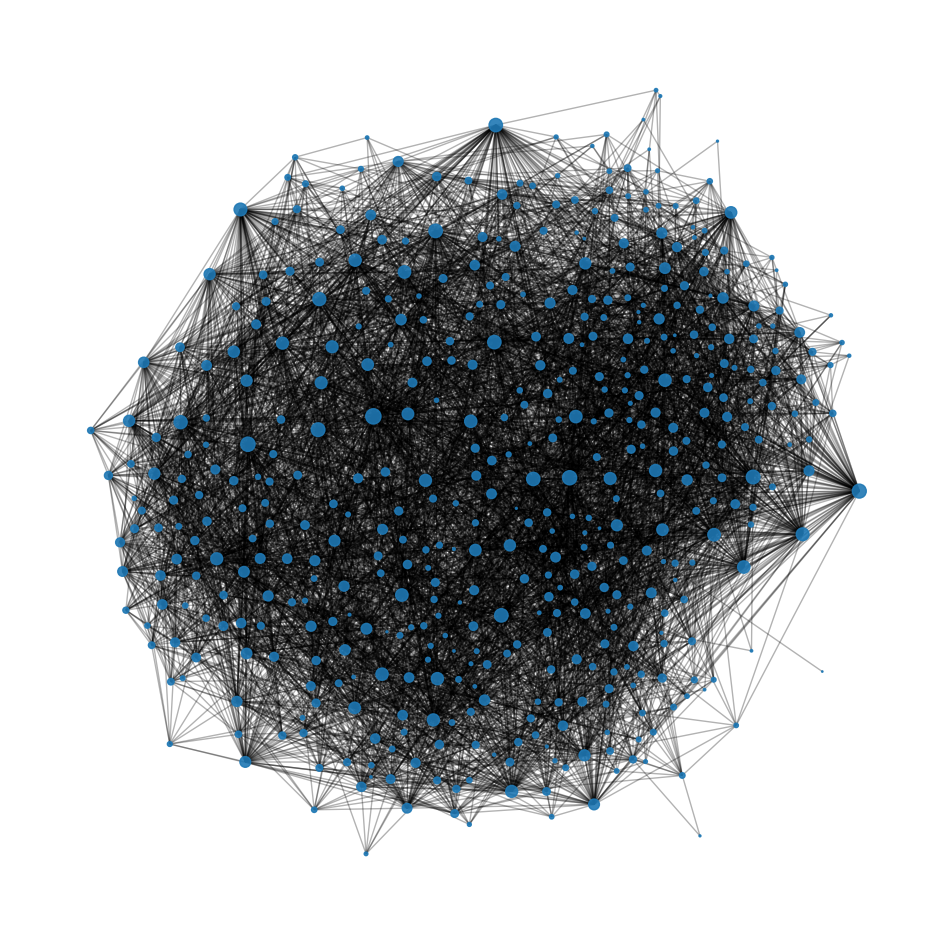

In [80]:
import networkx as nx
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import statistics
import matplotlib.pyplot as plt
import numpy as np
import powerlaw
from scipy.stats import spearmanr, pearsonr
import backboning as bb
from fa2_modified import ForceAtlas2
from collections import Counter

In [43]:
adjacency_matrix_url = r'https://raw.githubusercontent.com/GermanButtiero/social_graph_assignment1/main/files/rock_artists_adjacency_matrix.csv'
word_count_url = r'https://raw.githubusercontent.com/GermanButtiero/social_graph_assignment1/main/files/rock_artists_word_counts.csv'

adjacency_matrix = pd.read_csv(adjacency_matrix_url, index_col=0)
word_count_df = pd.read_csv(word_count_url)

In [44]:
G = nx.from_pandas_adjacency(adjacency_matrix, create_using=nx.DiGraph())
G.remove_nodes_from(list(nx.isolates(G)))
word_count_dict = pd.Series(word_count_df.Word_Count.values,index=word_count_df.Artist).to_dict()
nx.set_node_attributes(G, word_count_dict, 'word_count')

In [45]:
max_in_degree_node = max(G.in_degree(), key=lambda x: x[1])
print(f"Node with highest in-degree: {max_in_degree_node[0]} (In-degree: {max_in_degree_node[1]})")
neighbors = list(G.predecessors(max_in_degree_node[0]))
print(f"Neighbors of {max_in_degree_node[0]}: {neighbors}")

Node with highest in-degree: Led Zeppelin (In-degree: 127)
Neighbors of Led Zeppelin: ['311 (band)', 'Bryan Adams', 'Aerosmith', 'Alice in Chains', 'The Allman Brothers Band', 'Alter Bridge', 'Arctic Monkeys', 'Audioslave', 'Avenged Sevenfold', 'Bachman–Turner Overdrive', 'Bad Company', 'The Band', 'The Black Crowes', 'Black Sabbath', 'Blur (band)', 'Bon Jovi', 'Jeff Buckley', 'Bullet for My Valentine', 'Bush (British band)', 'Cheap Trick', 'Eddie Cochran', 'Coheed and Cambria', 'Phil Collins', 'Alice Cooper', 'Alice Cooper (band)', 'Chris Cornell', 'Cream (band)', 'Creed (band)', 'The Cult', 'Deep Purple', 'Def Leppard', 'Fats Domino', 'Donovan', 'Drowning Pool', 'Duran Duran', 'Electric Light Orchestra', 'England Dan & John Ford Coley', 'Europe (band)', 'The Everly Brothers', 'Faith No More', 'FireHouse', 'Foo Fighters', 'Foreigner (band)', 'Peter Frampton', 'Godsmack', 'Golden Earring', 'Greta Van Fleet', "Guns N' Roses", 'Heart (band)', 'Jimi Hendrix', "Herman's Hermits", 'Hinder',

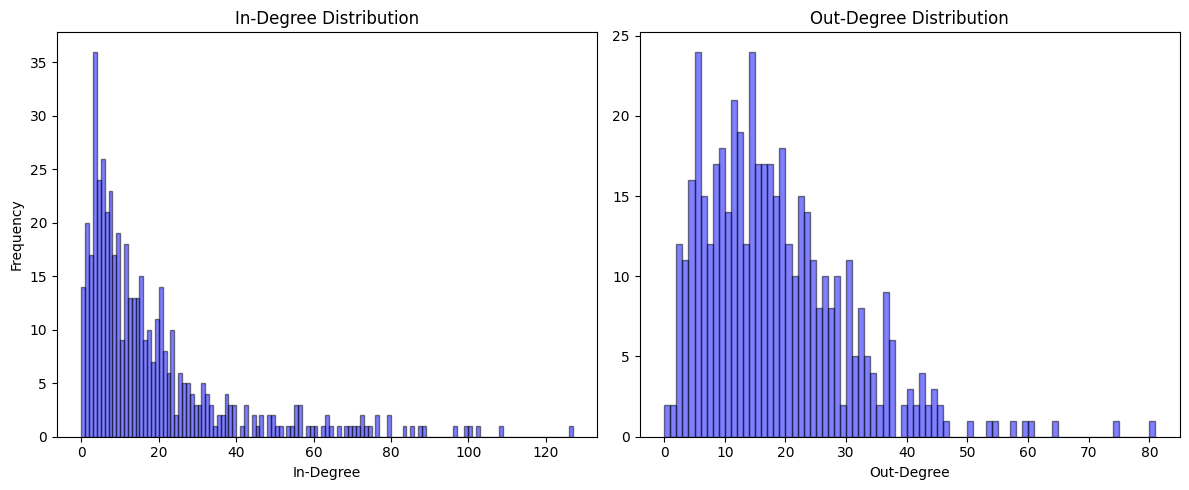

In [46]:
# The in-degrees and out-degrees of all nodes
in_degree = dict(G.in_degree())
out_degree = dict(G.out_degree())

# Binning
min_in_degree, max_in_degree = min(in_degree.values()), max(in_degree.values())
min_out_degree, max_out_degree = min(out_degree.values()), max(out_degree.values())

in_degree_vector = np.arange(min_in_degree, max_in_degree + 1)
out_degree_vector = np.arange(min_out_degree, max_out_degree + 1)

in_degree_hist = np.histogram(list(in_degree.values()), bins=in_degree_vector)
out_degree_hist = np.histogram(list(out_degree.values()), bins=out_degree_vector)

# Plot in-degree and out-degree distributions
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].hist(in_degree.values(), bins=in_degree_hist[1], color='blue', alpha=0.5, edgecolor='black')
ax[0].set_title('In-Degree Distribution')
ax[0].set_xlabel('In-Degree')
ax[0].set_ylabel('Frequency')

ax[1].hist(out_degree.values(), bins=out_degree_hist[1], color='blue', alpha=0.5, edgecolor='black')
ax[1].set_title('Out-Degree Distribution')
ax[1].set_xlabel('Out-Degree')

plt.tight_layout()
plt.show()

In [47]:
in_degrees = [degree for node, degree in in_degree.items()]
out_degrees = [degree for node, degree in out_degree.items()]
fig = px.scatter(
    x=in_degrees,
    y=out_degrees,
    labels={'x': 'In-Degree', 'y': 'Out-Degree'},
    title='In-Degree vs Out-Degree of Rock Artists',
)

fig.update_layout(template='plotly_white')

fig.add_shape(
    type='line',
    x0=0, y0=0,
    x1=max(in_degrees + out_degrees), y1=max(in_degrees + out_degrees),
    line=dict(dash='dash', color='red')
)

fig.show()

In [48]:
degree_stats = {
    'In-Degree': {
        'Average': statistics.mean(in_degrees),
        'Median': statistics.median(in_degrees),
        'Mode': statistics.mode(in_degrees),
        'Minimum': min(in_degrees),
        'Maximum': max(in_degrees)
    },
    'Out-Degree': {
        'Average': statistics.mean(out_degrees),
        'Median': statistics.median(out_degrees),
        'Mode': statistics.mode(out_degrees),
        'Minimum': min(out_degrees),
        'Maximum': max(out_degrees)
    }
}
degree_stats_df = pd.DataFrame(degree_stats)
display(degree_stats_df)

,In-Degree,Out-Degree
Average,17.933472,17.933472
Median,11.000000,16.000000
Mode,3.000000,14.000000
Minimum,0.000000,0.000000
Maximum,127.000000,81.000000


In [49]:
fit_in = powerlaw.Fit(in_degrees)
fit_out = powerlaw.Fit(out_degrees)
fit_total = powerlaw.Fit((in_degrees + out_degrees))

print(f"In-degree exponent α = {fit_in.alpha:.2f}")
print(f"Out-degree exponent α = {fit_out.alpha:.2f}")
print(f"Total-degree exponent α = {fit_total.alpha:.2f}")

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
In-degree exponent α = 2.56
Out-degree exponent α = 6.47
Total-degree exponent α = 3.65


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


In [50]:
lengths = np.array([G.nodes[n]['word_count'] for n in G.nodes()])
out_degrees = np.array([G.out_degree(n) for n in G.nodes()])

spearman_corr, spearman_p = spearmanr(lengths, out_degrees)
pearson_corr, pearson_p = pearsonr(lengths, out_degrees)

print(f"Spearman correlation (length vs out-degree): {spearman_corr:.2f}, p={spearman_p:.3f}")
print(f"Pearson correlation (length vs out-degree): {pearson_corr:.2f}, p={pearson_p:.3f}")

in_degrees = np.array([G.in_degree(n) for n in G.nodes()])

spearman_corr_in, spearman_p_in = spearmanr(lengths, in_degrees)
pearson_corr_in, pearson_p_in = pearsonr(lengths, in_degrees)

print(f"Spearman correlation (length vs in-degree): {spearman_corr_in:.2f}, p={spearman_p_in:.3f}")
print(f"Pearson correlation (length vs in-degree): {pearson_corr_in:.2f}, p={pearson_p_in:.3f}")


Spearman correlation (length vs out-degree): 0.73, p=0.000
Pearson correlation (length vs out-degree): 0.69, p=0.000
Spearman correlation (length vs in-degree): 0.68, p=0.000
Pearson correlation (length vs in-degree): 0.68, p=0.000


In [51]:
fig1 = px.scatter(x=lengths, y=out_degrees, labels={'x':'Length of content', 'y':'Out-degree'},title='Length of Content vs Out-degree')
fig1.show()

fig2 = px.scatter(x=lengths, y=in_degrees, labels={'x':'Length of content', 'y':'In-degree'},title='Length of Content vs In-degree')
fig2.show()

In [52]:
#Find the 5 most central characters according to degree centrality.
degree_centrality = nx.degree_centrality(G)
sorted_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)
top_5_central_nodes = sorted_centrality[:5]
print("Top 5 most central characters by degree centrality:")
for node, centrality in top_5_central_nodes:
    print(f"{node}: {centrality:.4f}")
    
#Find the 5 most central characters according to betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G)
sorted_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)
top_5_betweenness_nodes = sorted_betweenness[:5]
print("Top 5 most central characters by betweenness centrality:")
for node, centrality in top_5_betweenness_nodes:
    print(f"{node}: {centrality:.4f}")

Top 5 most central characters by degree centrality:
Led Zeppelin: 0.3354
Metallica: 0.3125
Black Sabbath: 0.2979
Queen (band): 0.2917
Bob Dylan: 0.2896
Top 5 most central characters by betweenness centrality:
Deep Purple: 0.0347
Beck: 0.0324
Guns N' Roses: 0.0313
Queen (band): 0.0298
Alice in Chains: 0.0288


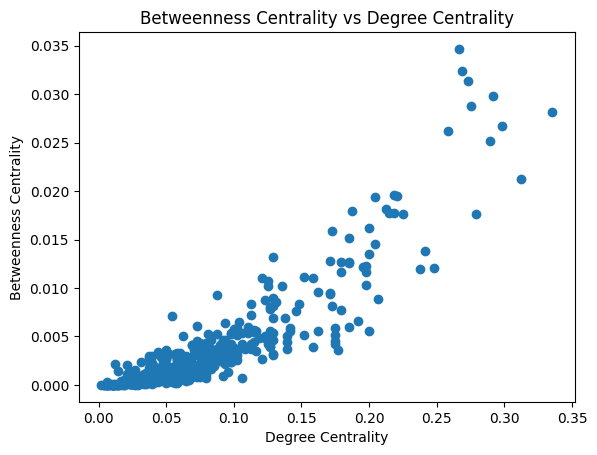

In [53]:
#Plot the betweenness centrality of nodes vs their degree centrality.
betweenness_values = [betweenness_centrality[n] for n in G.nodes()]
degree_values = [degree_centrality[n] for n in G.nodes()]

plt.scatter(degree_values, betweenness_values)
plt.xlabel("Degree Centrality")
plt.ylabel("Betweenness Centrality")
plt.title("Betweenness Centrality vs Degree Centrality")
plt.show()

In [54]:
#What is the average shortest path length?
if nx.is_strongly_connected(G):
    avg_shortest_path_length = nx.average_shortest_path_length(G)
    print(f"Average shortest path length: {avg_shortest_path_length:.4f}")
else:
    print("The graph is not strongly connected; average shortest path length is undefined.")

The graph is not strongly connected; average shortest path length is undefined.


In [55]:
G_undirected = G.to_undirected()
r = nx.degree_assortativity_coefficient(G_undirected)

att_att= nx.attribute_assortativity_coefficient(G_undirected, 'word_count')
print("Assortativity coefficients:")
print(f"Degree assortativity coefficient: {r:.4f}")
print(f"Attribute (word count) assortativity coefficient: {att_att:.4f}")

Assortativity coefficients:
Degree assortativity coefficient: -0.0121
Attribute (word count) assortativity coefficient: -0.0034


### Backboning

In [56]:
eb = nx.edge_betweenness_centrality(G_undirected)
values = list(eb.values())

scaled = np.interp(values, (min(values), max(values)), (1, 100))

for key, val in zip(eb.keys(), scaled):
    eb[key] = val

nx.set_edge_attributes(G_undirected, eb, "weight")

In [57]:
edge_df = nx.to_pandas_edgelist(G_undirected)
edge_df.rename(columns={"weight": "weight", "source": "src", "target": "trg"}, inplace=True)
file_path = "weighted_network1.csv"

edge_df.to_csv(file_path, sep="\t", index=False)

In [58]:
table, nnodes, nnedges = bb.read(file_path, "weight")
threshold_value = 0.05
nc_table = bb.noise_corrected(table)
nc_backbone = bb.thresholding(nc_table, threshold_value)
bb.write(nc_backbone, "network_name", "nc",  folder=".")

Calculating NC score...


In [59]:
net_backbone = nx.from_pandas_edgelist(
    nc_backbone,
    source='src',
    target='trg',
    edge_attr='nij',
    create_using=nx.Graph()  
)

In [60]:
# Remove isolated nodes
net_backbone = net_backbone.subgraph([n for n in net_backbone.nodes() if net_backbone.degree(n) > 0]).copy()

In [61]:
forceatlas2 = ForceAtlas2(
    outboundAttractionDistribution=True,  # Dissuade hubs
    linLogMode=False,
    adjustSizes=False,
    edgeWeightInfluence=1.0,
    jitterTolerance=1.0,
    barnesHutOptimize=True,
    barnesHutTheta=1.2,
    scalingRatio=2.0,
    strongGravityMode=False,
    gravity=1.0,
    verbose=True
)

positions = forceatlas2.forceatlas2_networkx_layout(net_backbone, pos=None, iterations=2000)

100%|██████████| 2000/2000 [00:07<00:00, 260.95it/s]

BarnesHut Approximation  took  1.26  seconds
Repulsion forces  took  5.90  seconds
Gravitational forces  took  0.06  seconds
Attraction forces  took  0.09  seconds
AdjustSpeedAndApplyForces step  took  0.25  seconds


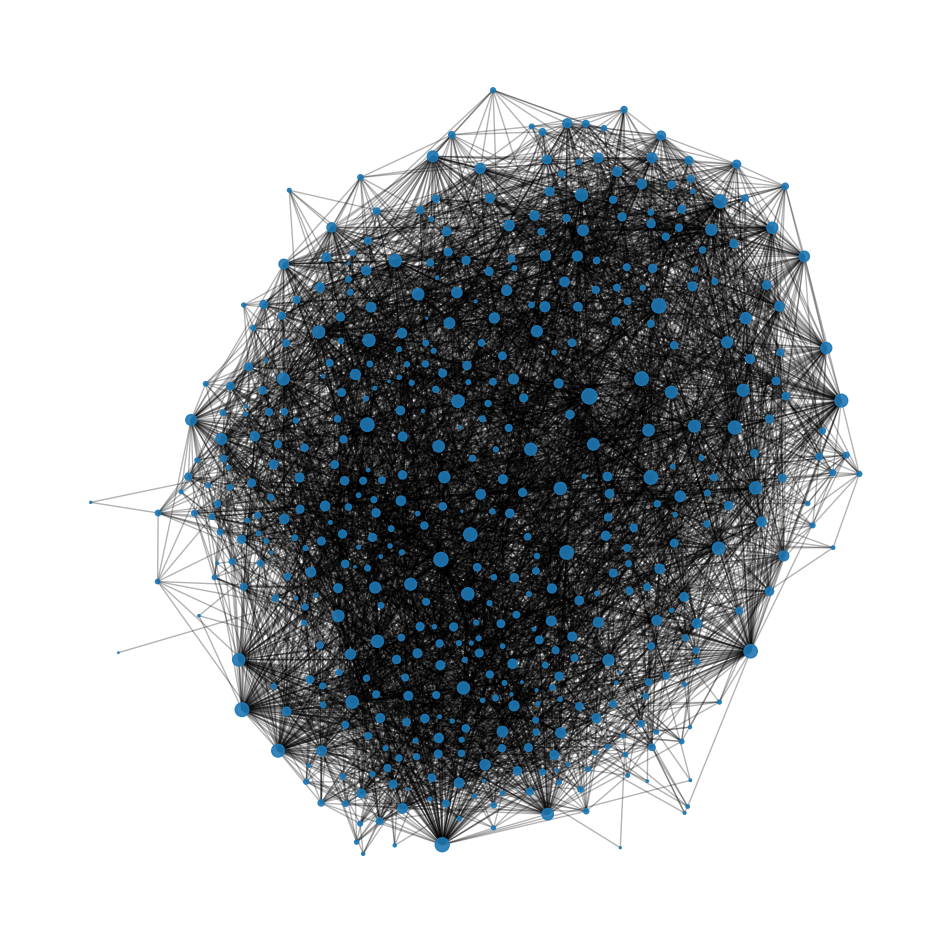

In [62]:
node_sizes = [net_backbone.degree(n) for n in net_backbone.nodes()]
plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(net_backbone, positions, node_size=node_sizes, alpha=0.9)
nx.draw_networkx_edges(net_backbone, positions, alpha=0.3)
plt.axis('off')
plt.show()

# Part 2: Genres and communities and plotting

The questions below are based on Lecture 7, part 2.

- Write about genres and modularity.
- Detect the communities, discuss the value of modularity in comparison to the genres.
- Calculate the matrix $D$ and discuss your findings.
- Plot the communities and comment on your results.

- Write about genres and modularity.



Modularity is a measure that helps us understand how well a network is divided into smaller groups, called communities. It tells us if some nodes are more connected to each other than to the rest of the network.
A high positive modularity means that the network has clear communities, where nodes are tightly connected inside their group and have fewer links to other groups. A modularity close to zero means the connections are more or less random, so there isn’t a clear community structure. A negative modularity would mean that the nodes do not form a community.

In this exercise, we add the genre of each artist as a node attribute, to check if the communities we find actually make sense in terms of genre. So as a first approach, we detect communities given their first genre. Secondly, since most of them have "rock" as first genre, we randomly select the main genre out of all the possible values that the node has. Lastly, we use the Louvain method to detect communities. We compare all modularities score to understand how community-like genres are.

- Detect the communities, discuss the value of modularity in comparison to the genres.

In [63]:
import json
import requests

In [64]:
url = "https://raw.githubusercontent.com/GermanButtiero/social_graph_assignment1/refs/heads/main/rock_artists_genres.json"
response = requests.get(url)
genres_dict = json.loads(response.text)

G_first_att = nx.Graph()
G_random_att = nx.Graph()
G_louvain = G.to_undirected()

for artist, genres in genres_dict.items():
    G_first_att.add_node(artist, genre=genres[0])
    G_random_att.add_node(artist, genre=genres[np.random.randint(len(genres))])

for artist1 in G_first_att.nodes:
    for artist2 in G_first_att.nodes:
        if artist1 != artist2 and G_first_att.nodes[artist1]['genre'] == G_first_att.nodes[artist2]['genre']:
            G_first_att.add_edge(artist1, artist2)

for artist1 in G_random_att.nodes:
    for artist2 in G_random_att.nodes:
        if artist1 != artist2 and G_random_att.nodes[artist1]['genre'] == G_random_att.nodes[artist2]['genre']:
            G_random_att.add_edge(artist1, artist2)

In [65]:
#delete nodes with no genre
nodes_to_remove = [n for n, attr in G_first_att.nodes(data=True) if 'genre' not in attr or not attr['genre']]
G_first_att.remove_nodes_from(nodes_to_remove)
G_random_att.remove_nodes_from(nodes_to_remove)
G_louvain.remove_nodes_from(nodes_to_remove)

In [66]:
def calculate_modularity(G, communities):
    L = G.number_of_edges()
    M = 0

    for genre, artists in communities.items():
        subgraph = G.subgraph(artists)
        L_c = subgraph.number_of_edges() 
        k_c = sum([G.degree(artist) for artist in artists]) 

        M += (L_c / L) - (k_c / (2 * L))**2

    return M

In [67]:
#communities given their first genre
first_genre_communities = {}
for node, data in G_first_att.nodes(data=True):
    genre = data['genre']
    if genre not in first_genre_communities:
        first_genre_communities[genre] = []
    first_genre_communities[genre].append(node)

print(calculate_modularity(G_first_att, first_genre_communities))

0.7462670398427846


A modularity score of 0.74 for a community generation given their first genres shows that rock artists are more keen to be connected with those other artists from the same genre than from the rest of the artists. This shows that genres are indeed good communities.

In [68]:
#communities given a random genre
random_genre_communities = {}
for node, data in G_random_att.nodes(data=True):
    genre = data['genre']
    if genre not in random_genre_communities:
        random_genre_communities[genre] = []
    random_genre_communities[genre].append(node)

print(calculate_modularity(G_random_att, random_genre_communities))

0.924433579329516


When we randomize which of each artist’s listed genres is selected as their main genre, we obtain a modularity score of 0.92, which is even higher than the one obtained using only their first genre.

In [69]:
#Louvain method
import community.community_louvain as community_louvain

louvain_partition = community_louvain.best_partition(G_louvain)

M_louvain = community_louvain.modularity(louvain_partition, G_louvain)
print(M_louvain)

0.30900494603563977


The Louvain algorithm produced a modularity of 0.3, which is lower than the modularity obtained when grouping artists by genre. This indicates that while there is some community structure in the network, it does not perfectly align with genres. The detected communities may capture other patterns (collaboration networks or popularity rather than purely genre-based connections).

- Calculate the matrix $D$ and discuss your findings.

In [86]:
top_communities = [community for community, _ in Counter(louvain_partition.values()).most_common(7)]

all_genres = [genre for genres in genres_dict.values() for genre in genres]
top_genres = [genre for genre, _ in Counter(all_genres).most_common(7)]


D = np.zeros((len(top_genres), len(top_communities)), dtype=int)

genre_index = {genre:index for index, genre in enumerate(top_genres)}
community_index = {community:index for index, community in enumerate(top_communities)}

for node, genres in genres_dict.items():
    community = louvain_partition.get(node)
    if community not in top_communities:
        continue

    for genre in genres:
        if genre in top_genres:
            genre_id = genre_index[genre]
            community_id = community_index[community]
            D[genre_id, community_id] += 1

print(D)

[[10 53 10 19]
 [28 14 32 10]
 [ 5 27 45  1]
 [52  1 10 11]
 [ 2 26 35  0]
 [ 3 28  2 17]
 [ 0 46  1  0]]


As shown in the matrix $D$ the seven most common genres are spread across the four Louvain-detected communities. This indicates that the communities found by the algorithm do not strictly correspond to the artists’ genres. Meaning that many communities contain artists from different genres, which suggests that the network structure is influenced by factors other than just musical style.

- Plot the communities and comment on your results.

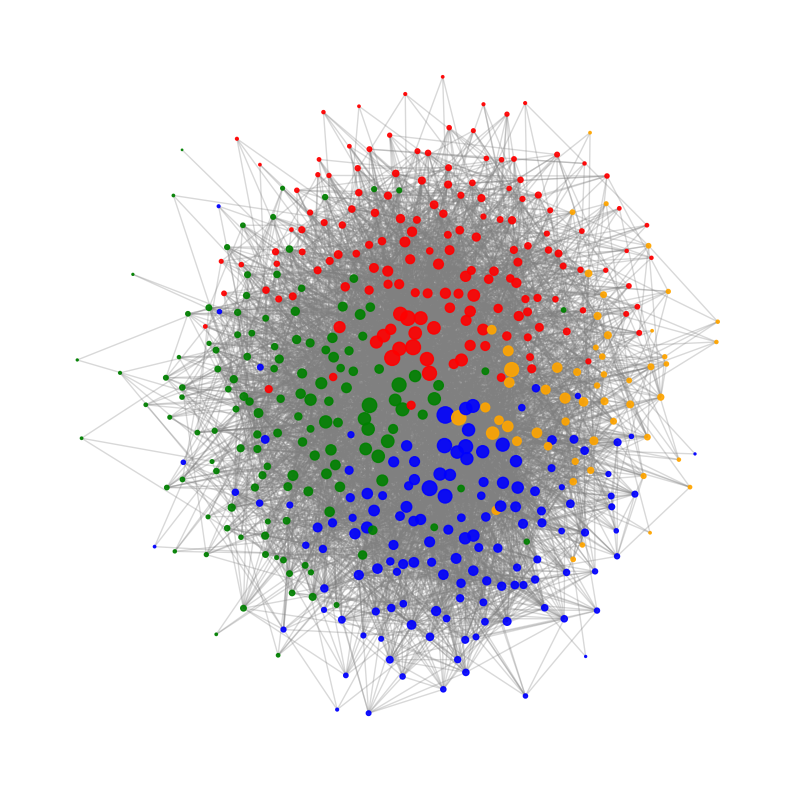

In [90]:
community_counts = {}
for community in louvain_partition.values():
    community_counts[community] = community_counts.get(community, 0) + 1

top_communities = sorted(community_counts, key=community_counts.get, reverse=True)[:5]

colors = ['red', 'blue', 'green', 'orange']
community_colors = {comm: colors[i % len(colors)] for i, comm in enumerate(top_communities)}

node_colors = [community_colors.get(louvain_partition[node], 'lightgray') for node in G_louvain.nodes]

pos = nx.kamada_kawai_layout(G_louvain)
node_sizes = [G_louvain.degree(n) for n in G_louvain.nodes()]

plt.figure(figsize=(10, 10))
nx.draw_networkx_nodes(G_louvain, pos, node_color=node_colors, node_size=node_sizes, alpha=0.9)
nx.draw_networkx_edges(G_louvain, pos, edge_color='gray', alpha=0.3)
plt.axis('off')
plt.show()

The plot shows the four communities detected by the Louvain algorithm. The size of each node represents its degree, so the larger nodes correspond to more connected or “important” artists within the network. Each community contains several highly connected nodes, while smaller nodes tend to be placed on the edges of the communities, acting as bridges or less central members.

# Part 3: TF-IDF to understand genres and communities

The questions below are based on Lecture 7, part 2, 4, 5, 6 (and a little bit on part 3).

- Explain the concept of TF-IDF in your own words and how it can help you understand the genres and communities.
- Calculate and visualize TF-IDF for the genres and communities.
- Use the matrix $D$ (Lecture 7, part 2) to dicusss the difference between the word-clouds between genres and communities.

# Part 4: Sentiment of the artists and communities

The questions below are based on Lecture 8

- Calculate the sentiment of the band/artist pages (it is OK to work with the sub-network of artists-with-genre) and describe your findings using stats and visualization, inspired by the first exercise of week 8.
- Discuss the sentiment of the communities. Do the findings using TF-IDF during Lecture 7 help you understand your results?